### Anomaly detection using PyOD

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

from imblearn.under_sampling import RandomUnderSampler
from pyod.models.iforest import IForest

In [2]:
# RESTART POINT

orig_train = pd.read_parquet("train_augmented.parquet")

In [3]:
orig_train.head()

,ip,app,device,os,channel,click_time,is_attributed,hour,day,ip_app_channel_var_day,qty,ip_app_count,ip_app_os_count,qty_var,ip_app_os_var,ip_app_channel_mean_hour
0,83230,3,1,13,379,2017-11-06 14:32:21,0,14,6,0.914338,1,5427,1326,7.893333,38.855403,8.619632
1,17357,3,1,19,379,2017-11-06 14:33:34,0,14,6,0.745750,1,5025,1380,9.618462,26.386922,8.090909
2,35810,3,1,13,379,2017-11-06 14:34:12,0,14,6,0.690244,1,2012,442,15.600000,34.029284,8.317073
3,45745,14,1,13,478,2017-11-06 14:34:52,0,14,6,0.883721,1,9474,1954,5.947712,39.259411,10.477273
4,161007,3,1,13,379,2017-11-06 14:35:08,0,14,6,0.619048,1,232,80,10.800000,37.221361,11.428571


In [4]:
# check for NaN, important for PyOD
orig_train.isna().sum()

ip                                0
app                               0
device                            0
os                                0
channel                           0
click_time                        0
is_attributed                     0
hour                              0
day                               0
ip_app_channel_var_day      3740046
qty                               0
ip_app_count                      0
ip_app_os_count                   0
qty_var                     4018896
ip_app_os_var               8899175
ip_app_channel_mean_hour          0
dtype: int64

In [5]:
# handle NaN
orig_train.fillna(value=0, inplace=True)

orig_train.isna().sum()

ip                          0
app                         0
device                      0
os                          0
channel                     0
click_time                  0
is_attributed               0
hour                        0
day                         0
ip_app_channel_var_day      0
qty                         0
ip_app_count                0
ip_app_os_count             0
qty_var                     0
ip_app_os_var               0
ip_app_channel_mean_hour    0
dtype: int64

In [6]:
TARGET = 'is_attributed'

# train, validation split
TRAIN_FRAC = 0.98

N_TRAIN = int(orig_train.shape[0] * TRAIN_FRAC)

# shuffle
orig_train = orig_train.sample(frac=1., random_state=12345)

df_train = orig_train[:N_TRAIN]
df_valid = orig_train[N_TRAIN:]

print('Original training samples:', df_train.shape[0])
print('Num. validation samples:', df_valid.shape[0])

Original training samples: 181205812
Num. validation samples: 3698078


In [7]:
feat = ['ip', 'app', 'device', 'os', 'channel',
       'hour', 'day', 'ip_app_channel_var_day', 'qty', 'ip_app_count',
       'qty_var', 'ip_app_os_count', 'ip_app_os_var',
       'ip_app_channel_mean_hour']

# removed ip because it is high card

cat_feat = ['app', 'device', 'os', 'channel']

x_train = df_train[feat]
y_train = df_train[TARGET]

x_valid = df_valid[feat]
y_valid = df_valid[TARGET]

rus = RandomUnderSampler(random_state=0, sampling_strategy=0.1)

In [8]:
x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

In [16]:
# let's try with undersampling the majority class
print('Train samples after resampling:', x_train_resampled.shape[0])

Train samples after resampling: 4925756


In [17]:
# provo PyOD con Isolation Forest
clf1 = IForest(behaviour="new", max_samples=500000, contamination=0.01, n_jobs=4, verbose=3, n_estimators=50)

In [18]:
%%time

# riprovo senza resampling
clf1.fit(x_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Building estimator 1 of 13 for this parallel run (total 50)...Building estimator 1 of 13 for this parallel run (total 50)...Building estimator 1 of 12 for this parallel run (total 50)...


Building estimator 1 of 12 for this parallel run (total 50)...
Building estimator 2 of 13 for this parallel run (total 50)...
Building estimator 2 of 12 for this parallel run (total 50)...
Building estimator 2 of 13 for this parallel run (total 50)...
Building estimator 2 of 12 for this parallel run (total 50)...
Building estimator 3 of 13 for this parallel run (total 50)...
Building estimator 3 of 12 for this parallel run (total 50)...
Building estimator 3 of 12 for this parallel run (total 50)...
Building estimator 3 of 13 for this parallel run (total 50)...
Building estimator 4 of 13 for this parallel run (total 50)...
Building estimator 4 of 13 for this parallel run (total 50)...
Building estimator 4 of 12 for this parallel run (total 50)...
Building estimator 4 of 12 for this parallel run (total

[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.8min finished


CPU times: user 2h 3min 28s, sys: 14min 48s, total: 2h 18min 17s
Wall time: 2h 12min 33s


IForest(behaviour='new', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples=500000, n_estimators=50, n_jobs=4,
    random_state=None, verbose=3)

In [19]:
print(clf1)

IForest(behaviour='new', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples=500000, n_estimators=50, n_jobs=4,
    random_state=None, verbose=3)


In [20]:
# computing AUC

y_pred = clf1.predict_proba(x_valid)
y_pred = y_pred[:, 1]
print('ROC computed is:', round(roc_auc_score(y_valid, y_pred), 4))

ROC computed is: 0.759


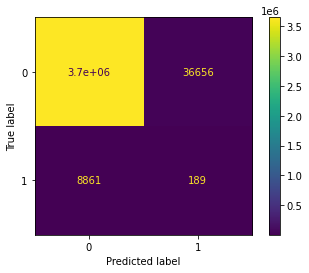

In [21]:
# computing Confusion Matrix
y_pred_label = clf1.predict(x_valid)
cm = confusion_matrix(y_valid, y_pred_label)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot();